In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


## **Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, GlobalMaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from wordcloud import WordCloud
from collections import Counter

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

import warnings 
warnings.filterwarnings("ignore")

2025-08-19 22:46:13.992725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755643574.360939      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755643574.461221      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_df = pd.read_csv(r"/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv")
valid_df = pd.read_csv(r"/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv")

In [4]:
train_df.columns = ['ID', 'Entity', 'Sentiment', 'Text']
valid_df.columns = ['ID', 'Entity', 'Sentiment', 'Text']

## **Exploring and cleaning data**

In [5]:
train_df.sample(10)

,ID,Entity,Sentiment,Text
61657,4969,GrandTheftAuto(GTA),Positive,"The dream is to fill a lobby in GTA IV Online,..."
16557,9636,PlayStation5(PS5),Positive,It was a real challenge.... [UNK]
727,2528,Borderlands,Negative,Surrender on the Border
60375,3545,Facebook,Irrelevant,22 Fear of prime
8650,9483,Overwatch,Positive,of short clips from our Football Console Divis...
66127,6924,johnson&johnson,Negative,Are they being sued for their baby powder? Nev...
2176,2781,Borderlands,Neutral,@Borderlands handsome quality free on mobile g...
43973,10352,PlayerUnknownsBattlegrounds(PUBG),Negative,I think bots in @PUBG is a terrible mistake. ....
62167,5057,GrandTheftAuto(GTA),Irrelevant,it's literally GTA in real life.
27159,1073,AssassinsCreed,Positive,And Shoutout to @Ubisoft for having finished a...


In [6]:
train_df['Sentiment'].value_counts()

Sentiment
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [7]:
print(train_df.isna().sum())
print(valid_df.isna().sum())

ID             0
Entity         0
Sentiment      0
Text         686
dtype: int64
ID           0
Entity       0
Sentiment    0
Text         0
dtype: int64


In [8]:
train_df.dropna(inplace = True)

In [9]:
print(train_df['Sentiment'].value_counts())
print(valid_df['Sentiment'].value_counts())

Sentiment
Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64
Sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    171
Name: count, dtype: int64


In [10]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = train_df[train_df.Sentiment != 'Irrelevant']
df_minority = train_df[train_df.Sentiment == 'Irrelevant']

df_minority_upsampled = resample(
    df_minority,
    replace = True,
    n_samples = df_majority['Sentiment'].value_counts().max(),
    random_state = 42
)

balanced_train_df = pd.concat([df_majority, df_minority_upsampled])

In [11]:
balanced_train_df['Sentiment'].value_counts()

Sentiment
Irrelevant    22358
Negative      22358
Positive      20654
Neutral       18108
Name: count, dtype: int64

In [12]:
# train_df.drop_duplicates(inplace = True)

In [13]:
balanced_train_df.shape, valid_df.shape

((83478, 4), (999, 4))

In [14]:
label_encoder = LabelEncoder()
balanced_train_df['Sentiment'] = label_encoder.fit_transform(balanced_train_df['Sentiment'])
balanced_train_df.sample(5)

,ID,Entity,Sentiment,Text
66286,6951,johnson&johnson,1,are
41397,1503,Battlefield,0,1 Bullying pilots with EPIC Tank launch shots ...
74322,9137,Nvidia,2,Hm? When did you get the best service? I misse...
53062,10716,RedDeadRedemption(RDR),3,I
24107,4532,Google,2,"Google Calendar can be messy, loud, and chaoti..."


In [15]:
balanced_train_df.drop(columns = ['ID', 'Entity'], inplace = True)

In [16]:
valid_df.drop(columns = ['ID', 'Entity'], inplace = True)
valid_df.sample(5)

,Sentiment,Text
168,Negative,Yo @NBA2K fuck your fake ass garbage ass game
884,Negative,@EAMaddenNFL is Madden NFL 21 still charging $...
152,Neutral,I didn't have massive success in #IndieApril b...
551,Neutral,Worked at Macy’s \n\nWorked at Chick Fil-A \n\...
492,Positive,FIFA 21 soars to the top of the charts this we...


In [17]:
valid_df['Sentiment'] = label_encoder.fit_transform(valid_df['Sentiment'])
valid_df.sample(5)

,Sentiment,Text
523,1,One game of fifa tonight and I’m done. Pressin...
551,2,Worked at Macy’s \n\nWorked at Chick Fil-A \n\...
448,2,Facebook employees reportedly feel guilty that...
368,3,"Thanks @RockstarGames , you're rock stars! #R..."
714,3,"Had a pretty amazing time streaming tonight, p..."


In [18]:
# train_df.sample(10)

In [19]:
balanced_train_df.isna().sum()
valid_df.isna().sum()

Sentiment    0
Text         0
dtype: int64

## **Text Preprocessing**

In [20]:
def processed_text(text):

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    
    # text normalization
    text = str(text).lower()
    # removing links
    text = re.sub(r"http\S+|www\S+|https\S+", ' ', text)
    # removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    text = re.sub(r"\d+", ' ', text)
    text = re.sub('<.*?>+', '', text)
    # remove extra spaces
    text = re.sub(r"\s+", ' ', text).strip()
    # remove emojis
    # text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    replace_list = {
        "isn't" : "is not",
        "won't" : "would not",
        "im" : "i am",
        "can't" : "can not",
        "don't" : "do not",
        "should't" : "should not",
        "needn't": "need not",
        "hasn't": "has not",
        "haven't": "have not",
        "weren't": "were not",
        "mightn't": "might not",
        "didn't": "did not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am",
    }
    # apply  replacements
    for pattern, replace in replace_list.items():
        text = re.sub(pattern, replace, text)

    words = text.split()
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(processed_words)

In [21]:
balanced_train_df['Text'] = balanced_train_df['Text'].apply(processed_text)
valid_df['Text'] = valid_df['Text'].apply(processed_text)

In [22]:
balanced_train_df['Text'].sample(5)

40206    ban battlefield player rid na vesiax occurred ...
27914                                know get people ai pc
29425    cli amb rating playapex tchtv boiyom discord d...
67962    yall please check amazing person getting amazi...
71486                                 terminated statement
Name: Text, dtype: object

In [23]:
# balanced_train_df.isna().sum()

In [24]:
# stemmer = PorterStemmer()
# stop_words = set(stopwords.words('english'))

# def preprocess_text(text):
#     words = text.split()
#     processed_words = [stemmer.stem(word) for word in words if word not in stop_words]
#     return ' '.join(processed_words)

# train_df['Text'] = train_df['Text'].apply(preprocess_text)
# valid_df['Text'] = valid_df['Text'].apply(preprocess_text)

In [25]:
# train_df.sample(5)

In [26]:
# label_encoder = LabelEncoder()
# train_df['Sentiment'] = label_encoder.fit_transform(train_df['Sentiment'])
# valid_df['Sentiment'] = label_encoder.fit_transform(valid_df['Sentiment'])

In [27]:
# train_df['Sentiment'].unique()

In [28]:
tokenizer = Tokenizer(num_words = 10000, oov_token = '<oov>')
tokenizer.fit_on_texts(balanced_train_df['Text'])

train_sequence = tokenizer.texts_to_sequences(balanced_train_df['Text'])
valid_sequence = tokenizer.texts_to_sequences(valid_df['Text'])

max_sequence_length = 100

x = pad_sequences(train_sequence, maxlen = max_sequence_length)  # Pad training sequences
x_val = pad_sequences(valid_sequence, maxlen = max_sequence_length)  # Pad validation sequences

In [29]:
import pickle

with open('tokenizer_2.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

print("Tokenizer has been saved.")

Tokenizer has been saved.


In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, balanced_train_df['Sentiment'], test_size = 0.2, random_state = 45)

In [31]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

train_labels = np.array(y_train)
test_labels = np.array(y_test)
val_labels = np.array(valid_df['Sentiment'].values)

## **Building Model**

In [32]:
model = Sequential([
    Embedding(input_dim = 10000, output_dim = 100, input_length = max_sequence_length),
    LSTM(64, return_sequences = True),
    SpatialDropout1D(0.2),
    LSTM(32),
    Dense(4, activation = 'softmax')
])

model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

check_point = ModelCheckpoint('sentiment_analysis1.h5', verbose = 0, save_best_only = True)

I0000 00:00:1755643611.197855      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755643611.198530      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [33]:
history = model.fit(
    x_train, train_labels,
    validation_data = (x_val, val_labels),
    epochs = 20,
    batch_size = 128,
    verbose = 1,
    callbacks = [check_point]
)

Epoch 1/20


I0000 00:00:1755643616.988975      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


522/522 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3260 - loss: 1.3636 - val_accuracy: 0.5255 - val_loss: 1.1642
Epoch 2/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5430 - loss: 1.0881 - val_accuracy: 0.6747 - val_loss: 0.8264
Epoch 3/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6618 - loss: 0.8418 - val_accuracy: 0.7447 - val_loss: 0.6801
Epoch 4/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7259 - loss: 0.7054 - val_accuracy: 0.7968 - val_loss: 0.5810
Epoch 5/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7658 - loss: 0.6150 - val_accuracy: 0.8318 - val_loss: 0.4986
Epoch 6/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7929 - loss: 0.5493 - val_accuracy: 0.8559 - val_loss: 0.4406
Epoch 7/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8119 - loss: 0.5044 - val_accuracy: 0.8689 - val_loss: 0.4253
Epoch 8/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8285 - loss: 0.4644 - val_accuracy: 0.87

In [34]:
test_loss, test_accuracy = model.evaluate(x_test,test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8221 - loss: 0.5635
Test Accuracy: 82.11%


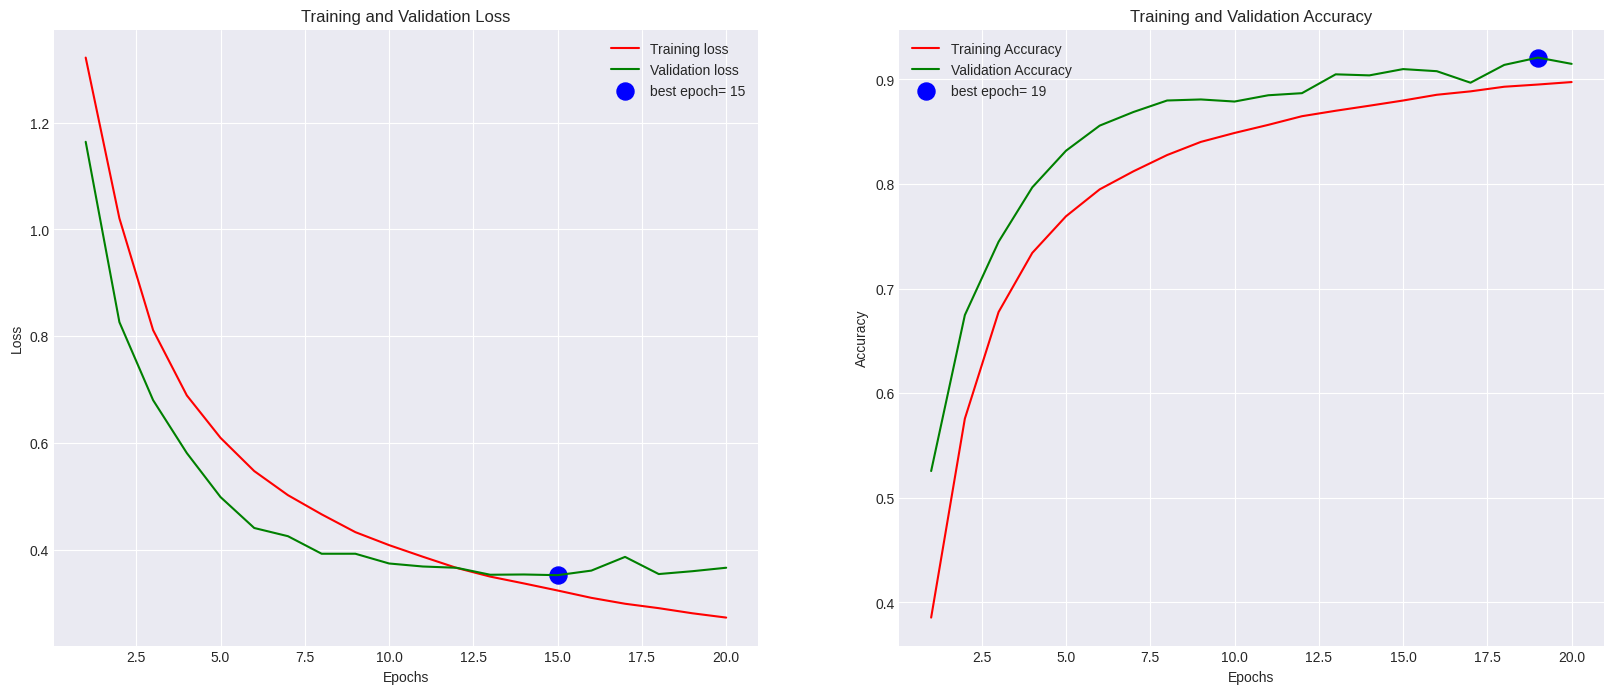

In [35]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('seaborn-v0_8-darkgrid')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [36]:
model.save('tesentmodel_v2.h5')

In [37]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


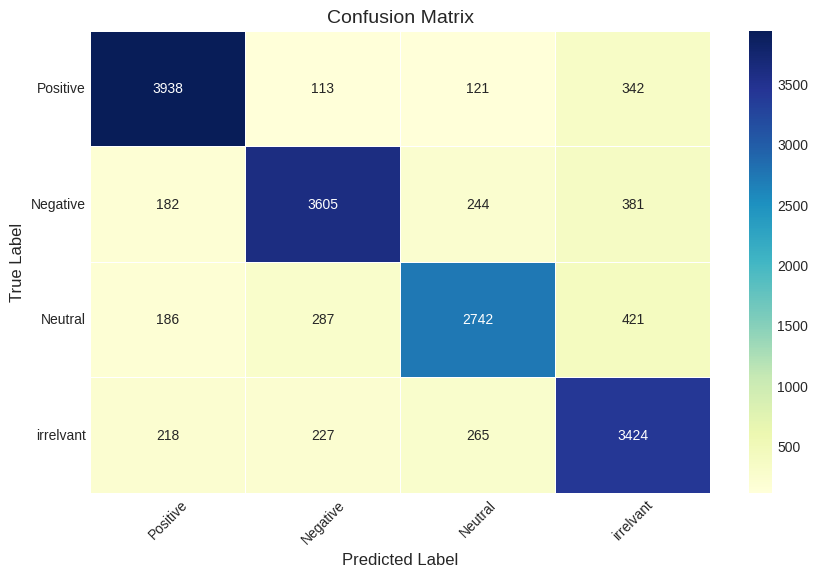

In [38]:
con_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,6))
sns.heatmap(con_matrix, annot=True, fmt='d', cmap="YlGnBu", xticklabels = ['Positive', 'Negative', 'Neutral','irrelvant'], yticklabels=['Positive', 'Negative', 'Neutral','irrelvant'], linewidths=0.5)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [39]:
report = classification_report(y_test, y_pred)
print('Classfication Report')
print(report)

Classfication Report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4514
           1       0.85      0.82      0.83      4412
           2       0.81      0.75      0.78      3636
           3       0.75      0.83      0.79      4134

    accuracy                           0.82     16696
   macro avg       0.82      0.82      0.82     16696
weighted avg       0.82      0.82      0.82     16696



In [40]:
def preprocess_txt(texts, tokenizer):
    """
    Preprocess new incoming text data.

    Args:
        texts (list of str): List of raw text inputs.
        tokenizer (Tokenizer): Pre-trained tokenizer.
        max_len (int): Maximum sequence length.

    Returns:
        np.array: Padded sequences ready for prediction.
    """
    # Convert text to sequences

    text_seq = tokenizer.texts_to_sequences([texts])
    
    # Apply padding
    text_padded = pad_sequences(text_seq, maxlen = 100, padding="post")
    
    return text_padded

In [41]:
def predict_data(text, model, tokenizer, max_len=100):
    text_cleaned = processed_text(text)
    
    # Convert to sequence
    seq = tokenizer.texts_to_sequences([text_cleaned])
    
    # Pad
    seq_padded = pad_sequences(seq, maxlen=max_len, padding="post")
    
    # Predict
    y_pred = model.predict(seq_padded)
    pred_idx = np.argmax(y_pred, axis=1)[0]
    
    classes = ['Positive', 'Negative', 'Neutral', 'Irrelevant']
    return classes[pred_idx]

In [42]:
with open('/kaggle/working/tokenizer_2.pkl', "rb") as f:
    tokenizer = pickle.load(f)


test_model = tf.keras.models.load_model('/kaggle/working/tesentmodel_v2.h5')

In [43]:
txt = "I absolutely hate this product! It hardly works and makes me so angry."

print("Processed:", processed_text(txt))
print("Sequences:", tokenizer.texts_to_sequences(processed_text(txt)))

pred_class = predict_data(txt, test_model, tokenizer)

print(f'Predicted Class :{pred_class}')

Processed: absolutely hate product hardly work make angry
Sequences: [[1], [236], [2531], [3318], [420], [12], [3311], [214], [420], [1], [], [358], [1], [3311], [214], [], [26], [204], [3318], [4178], [12], [173], [3311], [], [358], [1], [204], [4178], [420], [1], [], [267], [3318], [204], [18], [], [1575], [1], [18], [214], [], [1], [213], [208], [204], [1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Predicted Class :Irrelevant


In [44]:
txt = "I absolutely love this product! It works perfectly and makes me so happy."
text_padded = preprocess_txt([txt], tokenizer)
print(text_padded[0][:20])  # first 20 tokens after padding
pred = test_model.predict(text_padded)
print(np.argmax(pred))


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3
